# Sentiment analysis of reviews tonality from KinoPoisk

## Сбор данных

В качестве данных будут выступать отзывы на разные фильмы с сайта КиноПоиск

In [1]:
import time
import requests
from bs4 import BeautifulSoup
import pandas as pd
from fake_useragent import UserAgent
from tqdm import tqdm
import math
import numpy as np
import string
import nltk
from tensorflow.keras.preprocessing.text import Tokenizer
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers as l
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import utils
import os
import tensorflow as tf
from tensorflow import keras

In [2]:
'''
Функция скачивает отзывы с КиноПоиска.
Нужно еще доработать для настройки аргументов
АРГУМЕНТЫ ФУНКЦИИ:
reviews_count - если нужно ограничить кол-во отзывов всех видов (по умолч. скачивает все отзывы)
review_type - если нужны отзывы определенного типа ['bad', 'good', 'neutral'] (по умолч. скачивает все типы отзывов)
together - True, если нужно сохранить все отзывы в 1 файл (по умолч. False)
download - True, если нужно скачивать отзывы
'''
def get_reviews_KinoPoisk(reviews_count=None, review_type=None, together=False, download=True):
    
    def download_reviews(df, reviews_type, together):  # сохраняет датафреймы в csv файлы
        if together:  # если нужно сохранить все вместе
            df.to_csv('Data/all_reviews.csv', index=False)
        else:
            df.to_csv('Data/'+str(reviews_type)+'_reviews.csv', index=False)


    def kinopoisk_revs(rtype, reviews_count):  # тянет отзывы с КиноПоиска
        rev_per_page = 200
        base_url = 'https://www.kinopoisk.ru/reviews/type/comment/status/{0}/period/month/perpage/{1}/page/{2}/'
        page_numb = 1
        r_counter = reviews_count
        # пустой дф для последующего добавления отзывов
        rev_df = pd.DataFrame(columns=['review_text', 'review_type'])
        while True:  # пока есть отзывы (выход из цикла с помощью break)
            # если нужно ограничить кол-во отзывов
            if reviews_count and math.ceil(r_counter/rev_per_page) < page_numb:
                break
            response = requests.get(base_url.format(rtype, rev_per_page, page_numb),
                                    headers={'User-Agent': UserAgent().chrome})
            assert response.status_code == 200, 'Код ответа сервера: {}'.format(
                response.status_code)  # если сервер не доступен, то ошибка
            # выгружаем страницу отзывов
            soup = BeautifulSoup(response.text, 'html.parser')
            reviews_texts = [tag.get_text(strip=True) for tag in soup.select(
                '.brand_words span')]  # вычленяем отзывы по селектору
            page_numb += 1  # итератор страниц
            # если отзывов нет на странице, то выход из цикла (или если это уже лишние отзывы)
            if not len(reviews_texts):
                break            
            rev_df = rev_df.append(pd.DataFrame({'review_text': reviews_texts, 'review_type': rtype}),
                                   ignore_index=True)  # сохраняем все отзывы в датафрейм
        if not reviews_count:
            return rev_df
        else:
            if reviews_count > len(rev_df):
                reviews_count = len(rev_df)
            return rev_df.loc[0:reviews_count-1,:]


    if isinstance(review_type, str):  # если указан тип нужных отзывов
        rev_df = kinopoisk_revs(review_type, reviews_count)  # вытягиваем отзывы
    else:
        if not review_type:
            review_type = ['neutral', 'good', 'bad']  # все варианты отзывов
        iter_types = tqdm(review_type)  # для отображения прогресс-бара
        if together:  # если нужены все отзывы в 1 датафрейме
            common_df = pd.DataFrame(columns=['review_text', 'review_type'])
        for rtype in iter_types:  # перебираем все виды отзывов
            iter_types.set_description('Processing "{}" reviews'.format(
                rtype), refresh=True)  # добавляем свое описание для прогресса
            # Датафрейм с отзывами опред. типа
            rev_df = kinopoisk_revs(rtype, reviews_count)
            if together:
                common_df = common_df.append(rev_df, ignore_index=True)
        if together:
            rev_df = common_df
    if download:  # если нужно скачать отзывы
        download_reviews(rev_df, rtype, together)
    else:
        return rev_df

In [3]:
KinoPoisk_df = get_reviews_KinoPoisk(download=False, together=True)
KinoPoisk_df

Processing "bad" reviews: 100%|██████████████████████████████████████████████████████████| 3/3 [00:55<00:00, 18.40s/it]


,review_text,review_type
0,В девяностые и первую половину нулевых Голливу...,neutral
1,Тут все просто в пух и прах разносят экранизац...,neutral
2,«У каждого свои 90-е»- с этим утверждением тру...,neutral
3,Тезисно:Почему этот фильм не для всех?===Аляск...,neutral
4,«Трансформеры» для меня давно превратились во ...,neutral
...,...,...
2591,Сериал переполнен бесполезными мотивационными ...,bad
2592,Вселенной Ghost in the Shell категорически не ...,bad
2593,"Многие скажут, что этот проект — это экспансия...",bad
2594,"Независимые фильмы ужасов, столь любимые на вс...",bad


## Первичный анализ

На первый взгляд сразу вырисовываются очевидные проблемы:
- Необработанные отзывы (со знаками препинания, символами разметки и т.п.);
- Разный размер отзывов;
- Несбалансированная выборка;
- Три категории.

In [4]:
KinoPoisk_df.loc[0,'review_text'][:200]+'...'

'В девяностые и\xa0первую половину нулевых Голливудом была подарена своему верному зрителю целая плеяда достаточно увлекательных костоломных боевиков, ставших если не\xa0классикой, то\xa0приобретших определенны...'

In [5]:
len(KinoPoisk_df.loc[0,'review_text']), \
len(KinoPoisk_df.loc[1,'review_text']), \

(3874, 1410)

In [6]:
for t in KinoPoisk_df['review_type'].unique():
    print(t,len(KinoPoisk_df[KinoPoisk_df['review_type']==t]))

neutral 469
good 1660
bad 467


### Предобработка

In [7]:
# удаление знаков препинания, замена Заглавных букв строчными, исправление пробелов
def sentence_preprocessor(sentence):
    sentece = sentence.replace('\xa0', ' ').replace('.', ' ').replace('—', ' ').replace('  ', ' ').lower()
    sentece = ''.join(ch for ch in sentece if ch not in set(string.punctuation))
    return sentece

In [8]:
# nltk.download('stopwords')

In [9]:
stop_words= nltk.corpus.stopwords.words('russian')
def stopwords_deleter(sentence): # удаляет стоп-слова из предложения
    splits = sentence.split()
    for word in splits:
        if word in stop_words:
            splits.remove(word)
    return ' '.join(splits)

In [47]:
# удаляем стоп-слова и приводим строки в порядок
X = pd.Series([stopwords_deleter(sentence_preprocessor(sentence)) for sentence in KinoPoisk_df['review_text']])
# кодируем целевую переменную в формате one hot encoding
y = utils.to_categorical([0 if mark=='bad' else (1 if mark=='neutral' else 2) for mark in KinoPoisk_df['review_type']], len(KinoPoisk_df['review_type'].unique()))

## Выделение тестовой выборки

In [48]:
# разбили на тренировочную и тестовую выборку
X, X_test, y, y_test = train_test_split(X, y, test_size=0.1, random_state=2, shuffle=True, stratify=y)

### Токенизация

In [12]:
tokenizer = Tokenizer(num_words=10000)

In [13]:
tokenizer.fit_on_texts(X)

In [14]:
len(tokenizer.word_index), \
tokenizer.word_index

(112688,
 {'это': 1,
  'не': 2,
  'в': 3,
  'фильм': 4,
  'и': 5,
  'очень': 6,
  'что': 7,
  'фильма': 8,
  'просто': 9,
  'всё': 10,
  'который': 11,
  'как': 12,
  '10': 13,
  'на': 14,
  'которые': 15,
  'кино': 16,
  'же': 17,
  'его': 18,
  'фильме': 19,
  'все': 20,
  'время': 21,
  'он': 22,
  'этом': 23,
  'жизни': 24,
  'то': 25,
  'с': 26,
  'сюжет': 27,
  'так': 28,
  'хотя': 29,
  'том': 30,
  'именно': 31,
  'бы': 32,
  'лишь': 33,
  'сериал': 34,
  'своей': 35,
  'героев': 36,
  'я': 37,
  'только': 38,
  'её': 39,
  'история': 40,
  'даже': 41,
  'которая': 42,
  'также': 43,
  'ещё': 44,
  'вообще': 45,
  'однако': 46,
  'истории': 47,
  'жизнь': 48,
  'смотреть': 49,
  'людей': 50,
  'сказать': 51,
  'вот': 52,
  'по': 53,
  'было': 54,
  'стоит': 55,
  'если': 56,
  'есть': 57,
  'поэтому': 58,
  'их': 59,
  'нам': 60,
  'персонажей': 61,
  'лет': 62,
  'времени': 63,
  'герой': 64,
  'них': 65,
  'они': 66,
  'люди': 67,
  'роли': 68,
  'сериала': 69,
  'чтото': 70,

In [15]:
words_count_mean = []
for sentence in X:
    words_count_mean.append(
        len( (stopwords_deleter(sentence_preprocessor(sentence))).split() )
    )
num_words = math.ceil(np.mean(words_count_mean))
num_words

255

В среднем отзыв состоит из 256 слов.

In [16]:
sequences = tokenizer.texts_to_sequences(X)

In [17]:
print(X[0], end='\n\n')
print(sequences[0], len(sequences[0]))

девяностые первую половину нулевых голливудом подарена своему верному зрителю целая плеяда достаточно увлекательных костоломных боевиков ставших классикой приобретших определенный культ точно становится заметна тенденция реанимации этих поросших мхом хитов либо путем бессмысленных ребутов которые правило оказываются жалкой пародией оригинал либо путем внезапно разразившихся сиквелов яркий пример недавнего прошлого третья часть «трех иксов» вернувшая обратно строй лысого суперменаавтолюбителя самое видим сейчас выходом «плохие парни навсегда» bad boys for life 2020 принципе студийных боссов понять фоне штурмующих кинотеатры штамповок киновселенной marvel «фантастических тварей» взявших легкий передых «пиратов карибского моря» прочих «форсажей» ребятам sony которые сейчас выживают лишь счет оставшихся человекапаука «джуманджи» хочется усилить свои конкурентные позиции рынке развлекательного кино элементарный вариант заручиться хотя финансовой поддержкой майкла бэя внезапно выпустить трет

In [18]:
X = pad_sequences(sequences, maxlen=num_words)

In [19]:
len(X[0]), X[0]

(255,
 array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,   90,  349,  122, 1470,  358,  581,  136,
         804,  517, 1948,  453,  116,  656,  227, 3915,  535,   19,   81,
         910, 1581, 4090, 8859, 4091,  452,    6,  364,    1,   86,  142,
         644,  738,  461, 4092,  226,  456, 5473,  518,  558, 8063,  453,
         349,  122,    8,    6, 2132,   27, 4797, 1911,   64,   18,   89,
        1582, 8860,  138,  624, 8861,  610, 2377,  796, 1555, 3419, 9810,
         431,   18, 7366, 3737, 5474, 1374, 1374,  102, 6777, 2594, 5126,
         226, 1835, 8862,   23, 4093,  385,   22,   19, 1583, 1611,    8,
        1871,    6,  103,  650, 1009,  302, 1449, 8064, 9811,  244,  879,
        1471, 4318,  254,   54, 

### Выделение отложенной выборки

In [20]:
# выделили отложенную выборку
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=2, shuffle=True, stratify=y)

## Создание модели

In [21]:
len(X_train), len(X_val), len(X_test)

(2102, 234, 260)

### Сверточная нейросеть

In [42]:
first_model = Sequential([
    l.Embedding(15000, 256, input_length=num_words),
    l.Dropout(0.2),
    l.Conv1D(64, 5, padding='valid', activation='relu'),
    l.Dropout(0.2),
    l.Flatten(),
    l.Dense(3, activation='softmax')
])

first_model.compile(optimizer='adam',
                    loss='categorical_crossentropy',
                    metrics=['mae', 'categorical_accuracy', 'accuracy'])

first_model_path = 'first_best_model.h5'
checkpoint_first_model = ModelCheckpoint('Data/{}'.format(first_model_path),
                                         monitor='val_accuracy',
                                         save_best_only=True, verbose=True)

In [43]:
history_first_model = first_model.fit(X_train, 
                                      y_train, 
                                      epochs=25, 
                                      batch_size=400, 
                                      validation_data=(X_val, y_val),
                                      callbacks=[checkpoint_first_model],
                                     )

Train on 2102 samples, validate on 234 samples
Epoch 1/25
2000/2102 [===========================>..] - ETA: 0s - loss: 0.9769 - mae: 0.3689 - categorical_accuracy: 0.5510 - accuracy: 0.5510
Epoch 00001: val_accuracy improved from -inf to 0.64103, saving model to Data/first_best_model.h5
2102/2102 [==============================] - 17s 8ms/sample - loss: 0.9636 - mae: 0.3644 - categorical_accuracy: 0.5618 - accuracy: 0.5618 - val_loss: 0.9023 - val_mae: 0.3374 - val_categorical_accuracy: 0.6410 - val_accuracy: 0.6410
Epoch 2/25
2000/2102 [===========================>..] - ETA: 0s - loss: 0.8722 - mae: 0.3327 - categorical_accuracy: 0.6370 - accuracy: 0.6370
Epoch 00002: val_accuracy did not improve from 0.64103
2102/2102 [==============================] - 16s 8ms/sample - loss: 0.8690 - mae: 0.3327 - categorical_accuracy: 0.6394 - accuracy: 0.6394 - val_loss: 0.9056 - val_mae: 0.3649 - val_categorical_accuracy: 0.6410 - val_accuracy: 0.6410
Epoch 3/25
2000/2102 [========================

Epoch 20/25
2000/2102 [===========================>..] - ETA: 0s - loss: 0.0026 - mae: 0.0017 - categorical_accuracy: 1.0000 - accuracy: 1.0000
Epoch 00020: val_accuracy did not improve from 0.73077
2102/2102 [==============================] - 21s 10ms/sample - loss: 0.0026 - mae: 0.0017 - categorical_accuracy: 1.0000 - accuracy: 1.0000 - val_loss: 1.0490 - val_mae: 0.2143 - val_categorical_accuracy: 0.6923 - val_accuracy: 0.6923
Epoch 21/25
2000/2102 [===========================>..] - ETA: 1s - loss: 0.0023 - mae: 0.0015 - categorical_accuracy: 1.0000 - accuracy: 1.0000
Epoch 00021: val_accuracy did not improve from 0.73077
2102/2102 [==============================] - 21s 10ms/sample - loss: 0.0023 - mae: 0.0015 - categorical_accuracy: 1.0000 - accuracy: 1.0000 - val_loss: 1.0658 - val_mae: 0.2152 - val_categorical_accuracy: 0.6966 - val_accuracy: 0.6966
Epoch 22/25
2000/2102 [===========================>..] - ETA: 0s - loss: 0.0020 - mae: 0.0013 - categorical_accuracy: 1.0000 - accur

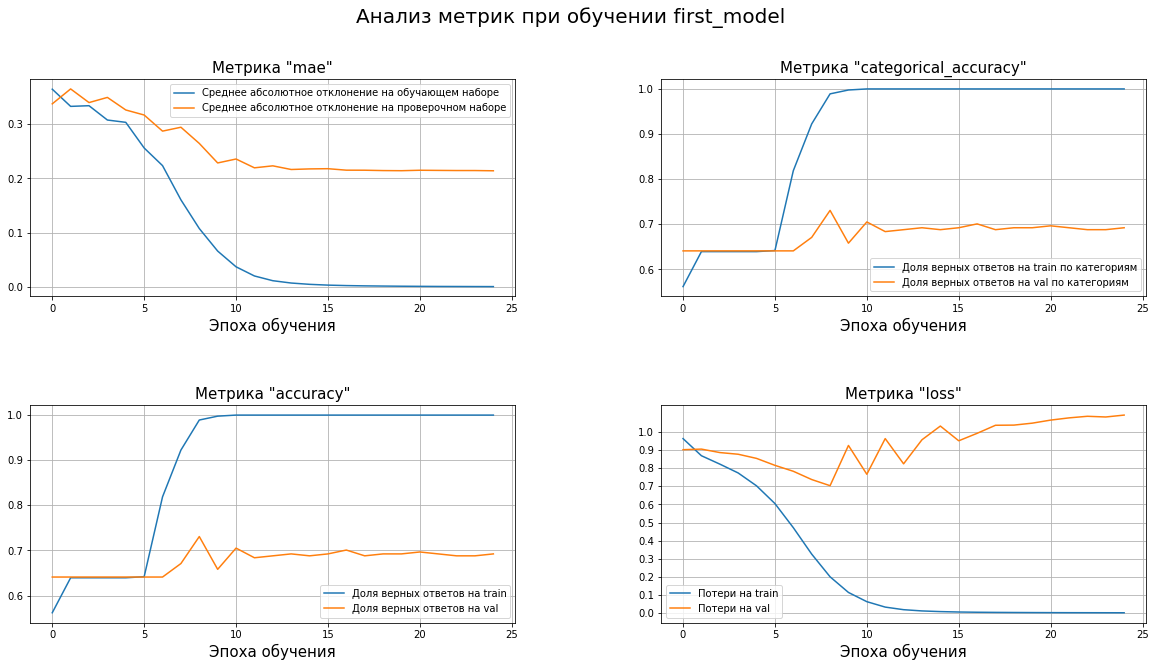

In [44]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))
fig.suptitle('Анализ метрик при обучении first_model', fontsize=20)
plt.subplots_adjust(wspace=0.3, hspace=0.5) # расстояние между графиками

for row_ax in ax:
    for ax_one in row_ax:
        ax_one.grid()
        ax_one.set_xlabel('Эпоха обучения', fontsize=15)
        ax_one.set_yticks(np.arange(0, 1.1, step=0.1))
        
ax[0,0].plot(history_first_model.history['mae'], 
             label='Среднее абсолютное отклонение на обучающем наборе')
ax[0,0].plot(history_first_model.history['val_mae'], 
             label='Среднее абсолютное отклонение на проверочном наборе')
ax[0,0].legend()
ax[0,0].set_title('Метрика "mae"', fontsize=15)


ax[0,1].plot(history_first_model.history['categorical_accuracy'], 
         label='Доля верных ответов на train по категориям')
ax[0,1].plot(history_first_model.history['val_categorical_accuracy'], 
         label='Доля верных ответов на val по категориям')
plt.xlabel('Эпоха обучения')
ax[0,1].legend()
ax[0,1].set_title('Метрика "categorical_accuracy"', fontsize=15)


ax[1,0].plot(history_first_model.history['accuracy'], 
         label='Доля верных ответов на train')
ax[1,0].plot(history_first_model.history['val_accuracy'], 
         label='Доля верных ответов на val')
ax[1,0].legend()
ax[1,0].set_title('Метрика "accuracy"', fontsize=15)


ax[1,1].plot(history_first_model.history['loss'], 
         label='Потери на train')
ax[1,1].plot(history_first_model.history['val_loss'], 
         label='Потери на val')
ax[1,1].legend()
ax[1,1].set_title('Метрика "loss"', fontsize=15);

После 9 эпохи начинает расти процент потери. Это может говорить о переобучении

In [45]:
first_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 255, 256)          3840000   
_________________________________________________________________
dropout_6 (Dropout)          (None, 255, 256)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 251, 64)           81984     
_________________________________________________________________
dropout_7 (Dropout)          (None, 251, 64)           0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 16064)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 48195     
Total params: 3,970,179
Trainable params: 3,970,179
Non-trainable params: 0
____________________________________________

### Демонстрация модели

### Подготовка тестовой выборки для предсказания 

In [49]:
sequences_test = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(sequences_test, maxlen=num_words)
X_test

array([[   0,    0,    0, ...,  775,  311,   13],
       [   0,    0,    0, ...,    4,  858,   22],
       [1165,    6, 1161, ..., 3729, 1945,  482],
       ...,
       [7942, 6589, 1025, ...,  471,  296,   13],
       [   0,    0,    0, ...,   20,  296, 3444],
       [   0,    0,    0, ...,    2,  598,   13]])

In [50]:
y_train

array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       ...,
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.]], dtype=float32)

In [51]:
# загружаем веса лучшей модели
first_model.load_weights('Data/{}'.format(first_model_path))
# Считаем качество на тестовой выборке
first_model.evaluate(X_test, y_test, verbose=1)

260/260 [==============================] - 0s 1ms/sample - loss: 0.7001 - mae: 0.2717 - categorical_accuracy: 0.7115 - accuracy: 0.7115


[0.7000515552667471, 0.27173054, 0.71153843, 0.71153843]

**Качество данной модели оставляет желать лучшего...**
<hr>
Создадим другую модель с другими комбинациями скрытых слоев

### Вторая модель (LSTM)

In [52]:
second_model = Sequential([
    l.Embedding(15000, 256, input_length=num_words),
    l.Dropout(0.2),
    l.LSTM(64),
    l.Dropout(0.2),
    l.Flatten(),
    l.Dense(3, activation='softmax')
])

second_model.compile(optimizer='adam',
                    loss='categorical_crossentropy',
                    metrics=['mae', 'categorical_accuracy', 'accuracy'])

second_model_path = 'second_best_model.h5'
checkpoint_first_model = ModelCheckpoint('Data/{}'.format(second_model_path),
                                         monitor='val_accuracy',
                                         save_best_only=True, verbose=True)

In [53]:
history_second_model = second_model.fit(X_train, y_train,
                                        epochs=25, 
                                        batch_size=400, 
                                        validation_data=(X_val, y_val),
                                        callbacks=[checkpoint_first_model],
                                       )

Train on 2102 samples, validate on 234 samples
Epoch 1/25
2000/2102 [===========================>..] - ETA: 0s - loss: 1.0775 - mae: 0.4395 - categorical_accuracy: 0.5465 - accuracy: 0.5465
Epoch 00001: val_accuracy improved from -inf to 0.64103, saving model to Data/second_best_model.h5
2102/2102 [==============================] - 23s 11ms/sample - loss: 1.0755 - mae: 0.4390 - categorical_accuracy: 0.5519 - accuracy: 0.5519 - val_loss: 1.0247 - val_mae: 0.4259 - val_categorical_accuracy: 0.6410 - val_accuracy: 0.6410
Epoch 2/25
2000/2102 [===========================>..] - ETA: 1s - loss: 0.9855 - mae: 0.4136 - categorical_accuracy: 0.6355 - accuracy: 0.6355
Epoch 00002: val_accuracy did not improve from 0.64103
2102/2102 [==============================] - 22s 10ms/sample - loss: 0.9798 - mae: 0.4117 - categorical_accuracy: 0.6394 - accuracy: 0.6394 - val_loss: 0.8955 - val_mae: 0.3710 - val_categorical_accuracy: 0.6410 - val_accuracy: 0.6410
Epoch 3/25
2000/2102 [=====================

Epoch 20/25
2000/2102 [===========================>..] - ETA: 1s - loss: 0.0038 - mae: 0.0025 - categorical_accuracy: 1.0000 - accuracy: 1.0000
Epoch 00020: val_accuracy did not improve from 0.72222
2102/2102 [==============================] - 31s 15ms/sample - loss: 0.0037 - mae: 0.0025 - categorical_accuracy: 1.0000 - accuracy: 1.0000 - val_loss: 1.5127 - val_mae: 0.2322 - val_categorical_accuracy: 0.6624 - val_accuracy: 0.6624
Epoch 21/25
2000/2102 [===========================>..] - ETA: 1s - loss: 0.0033 - mae: 0.0022 - categorical_accuracy: 1.0000 - accuracy: 1.0000
Epoch 00021: val_accuracy did not improve from 0.72222
2102/2102 [==============================] - 32s 15ms/sample - loss: 0.0033 - mae: 0.0022 - categorical_accuracy: 1.0000 - accuracy: 1.0000 - val_loss: 1.5210 - val_mae: 0.2334 - val_categorical_accuracy: 0.6410 - val_accuracy: 0.6410
Epoch 22/25
2000/2102 [===========================>..] - ETA: 1s - loss: 0.0027 - mae: 0.0018 - categorical_accuracy: 1.0000 - accur

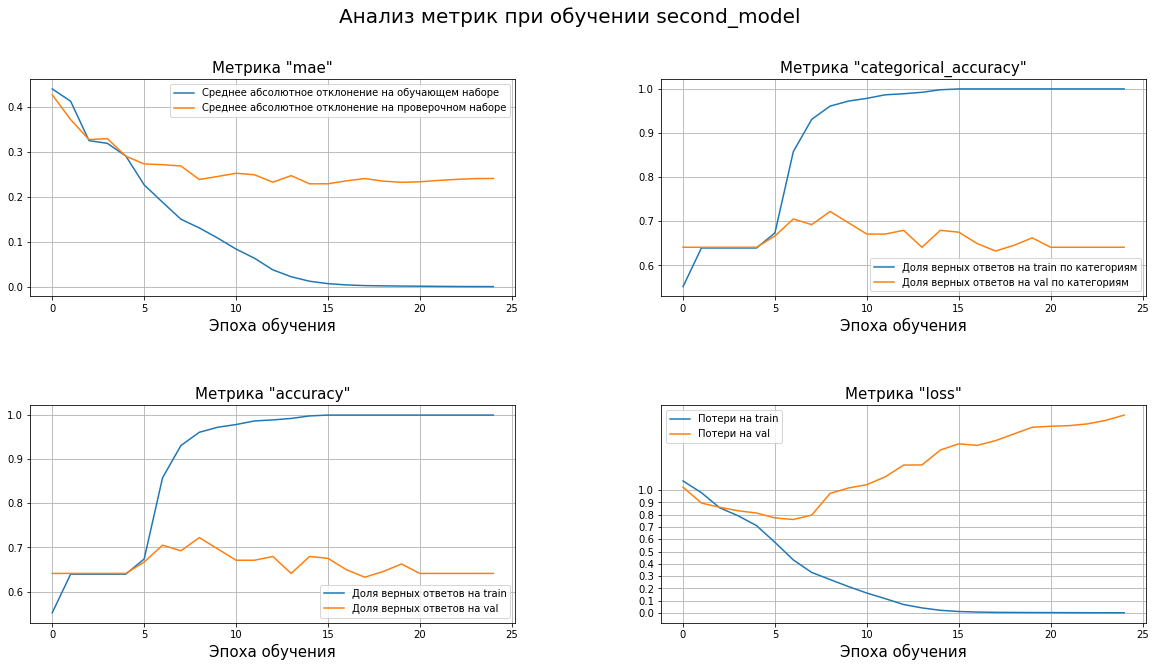

In [54]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))
fig.suptitle('Анализ метрик при обучении second_model', fontsize=20)
plt.subplots_adjust(wspace=0.3, hspace=0.5) # расстояние между графиками

for row_ax in ax:
    for ax_one in row_ax:
        ax_one.grid()
        ax_one.set_xlabel('Эпоха обучения', fontsize=15)
        ax_one.set_yticks(np.arange(0, 1.1, step=0.1))
        
ax[0,0].plot(history_second_model.history['mae'], 
             label='Среднее абсолютное отклонение на обучающем наборе')
ax[0,0].plot(history_second_model.history['val_mae'], 
             label='Среднее абсолютное отклонение на проверочном наборе')
ax[0,0].legend()
ax[0,0].set_title('Метрика "mae"', fontsize=15)


ax[0,1].plot(history_second_model.history['categorical_accuracy'], 
         label='Доля верных ответов на train по категориям')
ax[0,1].plot(history_second_model.history['val_categorical_accuracy'], 
         label='Доля верных ответов на val по категориям')
plt.xlabel('Эпоха обучения')
ax[0,1].legend()
ax[0,1].set_title('Метрика "categorical_accuracy"', fontsize=15)


ax[1,0].plot(history_second_model.history['accuracy'], 
         label='Доля верных ответов на train')
ax[1,0].plot(history_second_model.history['val_accuracy'], 
         label='Доля верных ответов на val')
ax[1,0].legend()
ax[1,0].set_title('Метрика "accuracy"', fontsize=15)


ax[1,1].plot(history_second_model.history['loss'], 
         label='Потери на train')
ax[1,1].plot(history_second_model.history['val_loss'], 
         label='Потери на val')
ax[1,1].legend()
ax[1,1].set_title('Метрика "loss"', fontsize=15);

In [55]:
second_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 255, 256)          3840000   
_________________________________________________________________
dropout_8 (Dropout)          (None, 255, 256)          0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                82176     
_________________________________________________________________
dropout_9 (Dropout)          (None, 64)                0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 195       
Total params: 3,922,371
Trainable params: 3,922,371
Non-trainable params: 0
____________________________________________

In [56]:
# загружаем веса лучшей модели
second_model.load_weights('Data/{}'.format(second_model_path))
# Считаем качество на тестовой выборке
second_model.evaluate(X_test, y_test, verbose=1)

260/260 [==============================] - 2s 7ms/sample - loss: 0.8865 - mae: 0.2366 - categorical_accuracy: 0.7077 - accuracy: 0.7077


[0.8864797450028933, 0.23659141, 0.7076923, 0.7076923]

### Сеть GRU

In [57]:
third_model = Sequential([
    l.Embedding(15000, 256, input_length=num_words),
    l.Dropout(0.2),
    l.GRU(64),
    l.Dropout(0.2),
    l.Flatten(),
    l.Dense(3, activation='softmax')
])

third_model.compile(optimizer='adam',
                    loss='categorical_crossentropy',
                    metrics=['mae', 'categorical_accuracy', 'accuracy'])

third_model_path = 'third_best_model.h5'
checkpoint_first_model = ModelCheckpoint('Data/{}'.format(third_model_path),
                                         monitor='val_accuracy',
                                         save_best_only=True, verbose=True)

In [58]:
history_third_model = third_model.fit(X_train, y_train,
                                        epochs=25, 
                                        batch_size=400, 
                                        validation_data=(X_val, y_val),
                                        callbacks=[checkpoint_first_model],
                                       )

Train on 2102 samples, validate on 234 samples
Epoch 1/25
2000/2102 [===========================>..] - ETA: 1s - loss: 1.0695 - mae: 0.4373 - categorical_accuracy: 0.5420 - accuracy: 0.5420
Epoch 00001: val_accuracy improved from -inf to 0.64103, saving model to Data/third_best_model.h5
2102/2102 [==============================] - 37s 17ms/sample - loss: 1.0672 - mae: 0.4366 - categorical_accuracy: 0.5466 - accuracy: 0.5466 - val_loss: 0.9936 - val_mae: 0.4160 - val_categorical_accuracy: 0.6410 - val_accuracy: 0.6410
Epoch 2/25
2000/2102 [===========================>..] - ETA: 1s - loss: 0.9609 - mae: 0.4038 - categorical_accuracy: 0.6390 - accuracy: 0.6390
Epoch 00002: val_accuracy did not improve from 0.64103
2102/2102 [==============================] - 34s 16ms/sample - loss: 0.9590 - mae: 0.4030 - categorical_accuracy: 0.6394 - accuracy: 0.6394 - val_loss: 0.8935 - val_mae: 0.3713 - val_categorical_accuracy: 0.6410 - val_accuracy: 0.6410
Epoch 3/25
2000/2102 [======================

2000/2102 [===========================>..] - ETA: 1s - loss: 0.0016 - mae: 0.0011 - categorical_accuracy: 1.0000 - accuracy: 1.0000
Epoch 00019: val_accuracy did not improve from 0.73932
2102/2102 [==============================] - 30s 14ms/sample - loss: 0.0016 - mae: 0.0011 - categorical_accuracy: 1.0000 - accuracy: 1.0000 - val_loss: 1.8170 - val_mae: 0.2424 - val_categorical_accuracy: 0.6325 - val_accuracy: 0.6325
Epoch 20/25
2000/2102 [===========================>..] - ETA: 1s - loss: 0.0013 - mae: 8.8526e-04 - categorical_accuracy: 1.0000 - accuracy: 1.0000
Epoch 00020: val_accuracy did not improve from 0.73932
2102/2102 [==============================] - 30s 14ms/sample - loss: 0.0014 - mae: 8.9625e-04 - categorical_accuracy: 1.0000 - accuracy: 1.0000 - val_loss: 1.8515 - val_mae: 0.2439 - val_categorical_accuracy: 0.6368 - val_accuracy: 0.6368
Epoch 21/25
2000/2102 [===========================>..] - ETA: 1s - loss: 0.0011 - mae: 7.1859e-04 - categorical_accuracy: 1.0000 - accur

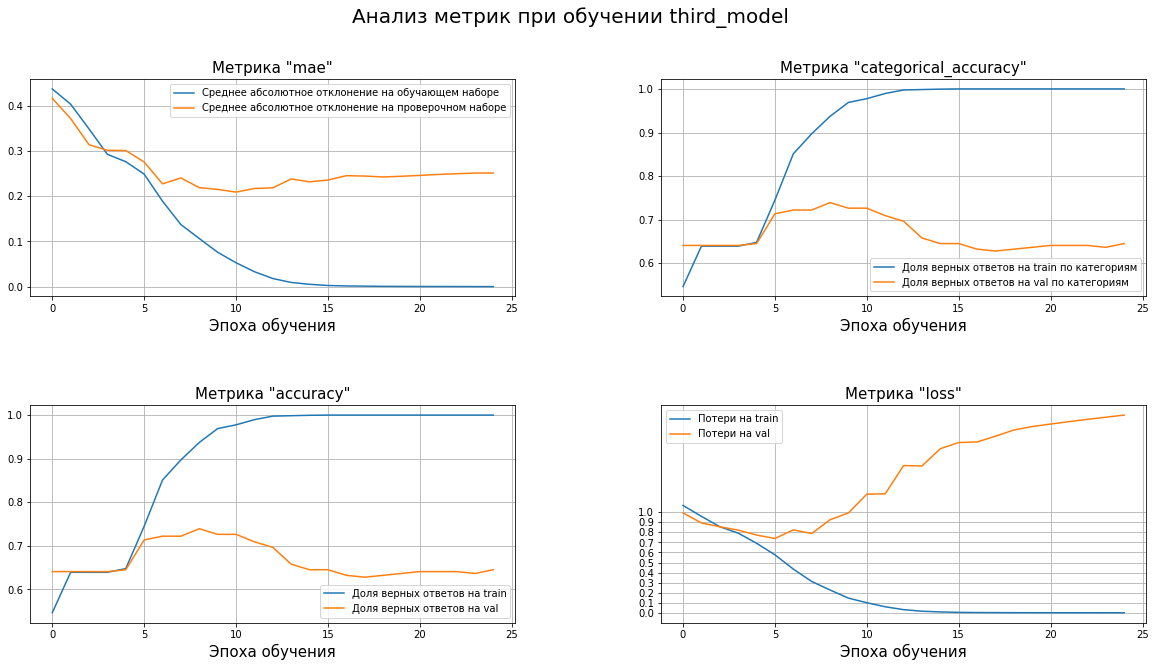

In [59]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))
fig.suptitle('Анализ метрик при обучении third_model', fontsize=20)
plt.subplots_adjust(wspace=0.3, hspace=0.5) # расстояние между графиками

for row_ax in ax:
    for ax_one in row_ax:
        ax_one.grid()
        ax_one.set_xlabel('Эпоха обучения', fontsize=15)
        ax_one.set_yticks(np.arange(0, 1.1, step=0.1))
        
ax[0,0].plot(history_third_model.history['mae'], 
             label='Среднее абсолютное отклонение на обучающем наборе')
ax[0,0].plot(history_third_model.history['val_mae'], 
             label='Среднее абсолютное отклонение на проверочном наборе')
ax[0,0].legend()
ax[0,0].set_title('Метрика "mae"', fontsize=15)


ax[0,1].plot(history_third_model.history['categorical_accuracy'], 
         label='Доля верных ответов на train по категориям')
ax[0,1].plot(history_third_model.history['val_categorical_accuracy'], 
         label='Доля верных ответов на val по категориям')
plt.xlabel('Эпоха обучения')
ax[0,1].legend()
ax[0,1].set_title('Метрика "categorical_accuracy"', fontsize=15)


ax[1,0].plot(history_third_model.history['accuracy'], 
         label='Доля верных ответов на train')
ax[1,0].plot(history_third_model.history['val_accuracy'], 
         label='Доля верных ответов на val')
ax[1,0].legend()
ax[1,0].set_title('Метрика "accuracy"', fontsize=15)


ax[1,1].plot(history_third_model.history['loss'], 
         label='Потери на train')
ax[1,1].plot(history_third_model.history['val_loss'], 
         label='Потери на val')
ax[1,1].legend()
ax[1,1].set_title('Метрика "loss"', fontsize=15);

In [60]:
# загружаем веса лучшей модели
third_model.load_weights('Data/{}'.format(third_model_path))
# Считаем качество на тестовой выборке
third_model.evaluate(X_test, y_test, verbose=1)

260/260 [==============================] - 1s 5ms/sample - loss: 0.9579 - mae: 0.2505 - categorical_accuracy: 0.6923 - accuracy: 0.6923


[0.9579317312974196, 0.25047335, 0.6923077, 0.6923077]